In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

import os
os.chdir("Experiments/Scripts")

from synthetic_data import *
from proposal_epidemic import *
from smc import *


SImulate the data (the epidemic might die several time, we suggest to run the code until you get a sensible SIS outcome)

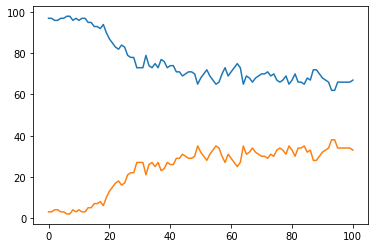

In [5]:
N = 100
M = 2
covariates_n = 2

W = np.random.normal(1, 0, (N, 1))
for i in range(covariates_n-1):

    cov = np.random.normal(0, 1, (N, 1))
    W = np.concatenate((W, cov), axis =1)

W           = tf.convert_to_tensor( W,                      dtype = tf.float32 )
beta_0      = tf.convert_to_tensor( [[-np.log(N-1)], [+0]], dtype = tf.float32 ) 
beta_lambda = tf.convert_to_tensor( [[-1],           [+2]], dtype = tf.float32 ) 
beta_gamma  = tf.convert_to_tensor( [[-1],           [-1]], dtype = tf.float32 ) 

T     = 100
initial_distribution  = AB_initial(W, beta_0)
K_eta = AB_SIS_transition(W, beta_lambda, beta_gamma)
q     = tf.convert_to_tensor([[0.8], [0.8]], dtype = tf.float32)

EXP = compartmental_model(N, M, initial_distribution, K_eta, q)
C, Y = EXP.run(T)

for i in range(C.shape[1]):
    plt.plot(np.sum(C, axis =0)[i, :])

Run the multinomial approximation

In [10]:
pi_0 = mean_SIS_initial(initial_distribution)

# K_eta_hom  = homogeneous_SIS_transition( N, beta, gamma)
K_eta_mean = mean_SIS_transition(K_eta)

multi_approx = multinomial_approximation(N, M, pi_0, K_eta_mean, q)
pi, pi_T = multi_approx.run(Y)


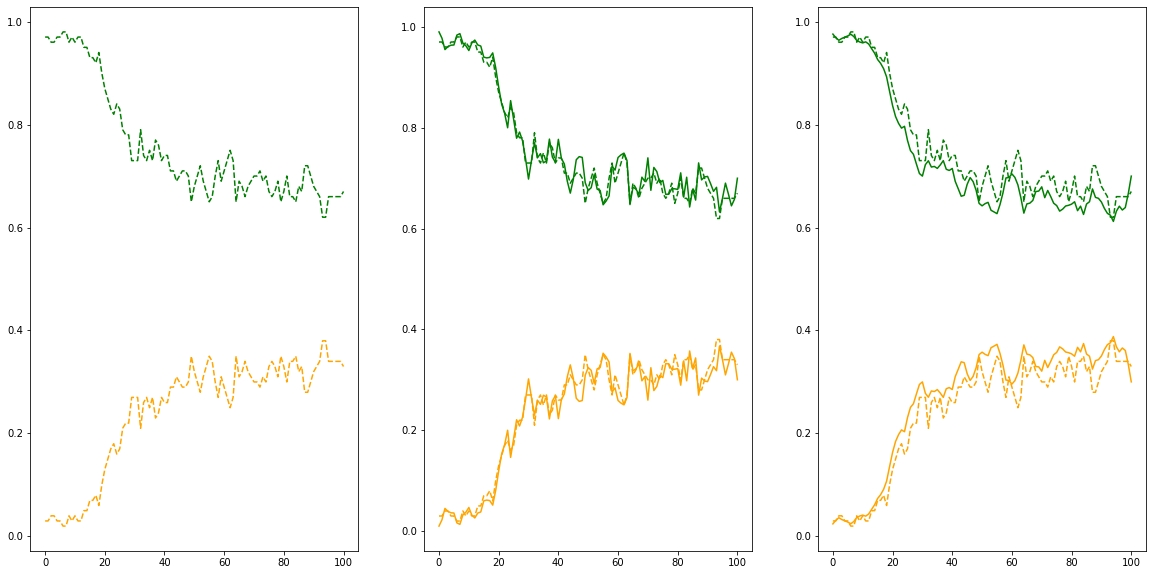

In [11]:
colors = ["green", "orange", "red", "blue"]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 10))

for i in range(M):
    ax[0].plot(tf.reduce_sum(C, axis = 0)[i,:]/N, color = colors[i], linestyle ="--")

for i in range(M):
    ax[1].plot(tf.reduce_sum(C, axis = 0)[i,:]/N, color = colors[i], linestyle ="--")
    ax[1].plot(pi[i,:], color = colors[i])

for i in range(M):
    ax[2].plot(tf.reduce_sum(C, axis = 0)[i,:]/N, color = colors[i], linestyle ="--")
    ax[2].plot(pi_T[i,:], color = colors[i])

Run the smc

In [9]:
K_eta_multi = AB_SIS_transition_multi(W, beta_lambda, beta_gamma)

Nx = 1028
h=5

proposal = alternative_proposal(Nx, N, M, initial_distribution, K_eta, K_eta_multi, q, h, pi_T)

SMC_proposal = smc(proposal)
X, ESS_history, loglikelihood = SMC_proposal.run(Y)

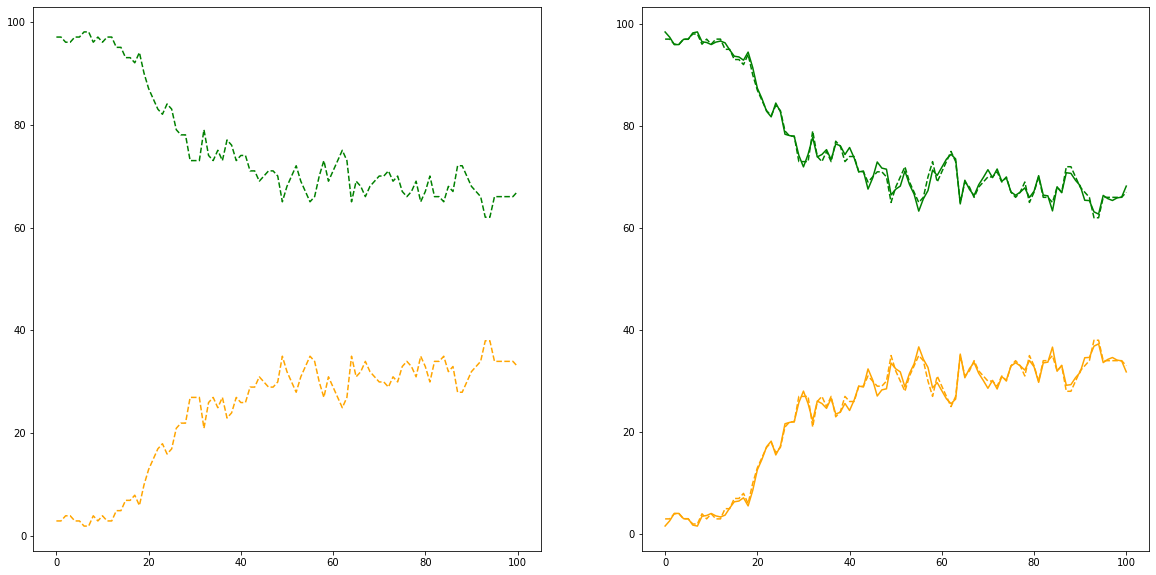

In [13]:
colors = ["green", "orange", "red", "blue"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 10))

for i in range(M):
    ax[0].plot(tf.reduce_sum(C, axis = 0)[i,:], color = colors[i], linestyle ="--")

for i in range(M):
    ax[1].plot(tf.reduce_sum(C, axis = 0)[i,:], color = colors[i], linestyle ="--")
    ax[1].plot(tf.reduce_mean(X[:,i,:], axis = 0), color = colors[i])
